# Use case for cosine similarity

## 1. Set Up

Set up Google Colab environment

In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

# Install sentence-transformers
pip install -U sentence-transformers

In [ ]:
from tqdm.notebook import tqdm
import time
from bs4 import BeautifulSoup
import pandas as pd
import re
import random

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

## 2. Download data

In [ ]:
def casting_text_to_int(text):
  try:
    if ('.' not in text):
      casted_int = int(text.replace(',', ''))
    else:
      casted_int = float(text.replace(',', ''))
  except AttributeError:
    casted_int = 'NonTextError'
  except Exception:
    casted_int = 'NonNumberError'

  return casted_int

def remove_html_tags(text):
  """Remove html tags from a string"""
  clean = re.compile(r'<[^>]+>')
  return re.sub(clean, '', text)

*   path: path to save file in content folder
*   year: year of program courses



In [ ]:
path = "/content"
year = "2022-23"
### This is the number of pages
num_of_program_pages_display = 1
column_labels = [['Course Code', 'Course Title', \
                    'Description', 'Intended Learning Outcomes']]
text_contents = []
program_urls = []
total_course_cnt = 0

### Random port number to avoid connection refused
port_num = random.randint(49152, 65536)
driver = webdriver.Chrome('chromedriver', port=port_num, options=chrome_options)
### Get all the Postgraduate Programs URLs first
url = "https://prog-crs.hkust.edu.hk/pgcourse/{}".format(year)
driver.get(url)
print(url)
time.sleep(3)

print("Start to crawl Programs' URLs:")

for i in tqdm(range(num_of_program_pages_display)):
  
  tqdm.write("Crawling Postgraduate Programs URLs from Catalog page {}\r".format(i+1))

  try:
    program_list = driver.find_elements(By.XPATH, "//ul[@class='subject-list']//li")
  except Exception:
    pass

  for i in tqdm(range(len(program_list))):
    each_program = program_list[i]
    program_url = each_program.find_element(By.XPATH, ".//a").get_attribute('href')
    if (program_url not in program_urls):
      program_urls.append(program_url)

### For debug only
# for program_url in program_urls:
#   print(program_url)
### For debug only

### Start to visit the Postgraduate Courses' pages and extract information
print("Start to visit Postgraduate Courses' pages:")

for i in tqdm(range(len(program_urls[:]))):
  program_url = program_urls[i]
  tqdm.write('Visiting Postgraduate Courses page {}: {}\r'.format(i+1, program_url))
  
  try:
    driver.get(program_url)
    time.sleep(1)
    soup = BeautifulSoup(driver.page_source, "html.parser")
    course_list = soup.find_all("li", attrs={"class": "crse accordion-item"})
    ### For debug only
    # for course in course_list:
    #   total_course_cnt += 1
    #   course_code = course.find("div", attrs={"class": "crse-code"})
    #   course_title = course.find("div", attrs={"class": "crse-title"})
    #   course_data = course.find_all("div", attrs={"class": "data"})
    #   course_desc = course_data[-2]
    #   course_outcomes = course_data[-1]
    #   print("Course code: {}, Course title: {}".format(course_code.get_text(), course_title.get_text()))
    #   print("Course desc: {}".format(course_desc.get_text()))
    #   print("Course outcomes: {}".format(course_outcomes.get_text()))
    ### For debug only
  except Exception:
    text_contents.append(['Program URL Error {}'.format(program_url)])
    continue

  for course in course_list:
    ### Try to get program name
    total_course_cnt += 1

    try:
      course_code = course.find("div", attrs={"class": "crse-code"})
      course_code_str = course_code.get_text()
    except Exception:
      course_code_str = 'No course code error {}'.format(program_url)
      pass

    ### Try to get course title
    try:
      course_title = course.find("div", attrs={"class": "crse-title"})
      course_title_str = course_title.get_text()
    except Exception:
      course_title_str = 'No course title error {}'.format(program_url)
      pass

    ### Try to get intro & outcome info
    try:
      course_data = course.find_all("div", attrs={"class": "data"})
      course_desc = course_data[-2]
      course_outcomes = course_data[-1]
      course_desc_str = course_desc.get_text()
      course_outcomes_str = course_outcomes.get_text()
    except Exception:
      course_desc_str = 'No course desc error {}'.format(program_url)
      course_outcomes_str = 'No course outcomes error {}'.format(program_url)
      pass
  
    text_contents.append([course_code_str, course_title_str, course_desc_str, course_outcomes_str])

### For debug only
# for u_text in text_contents:
#   print(u_text)
### For debug only

### Convert the lists to Pandas Dataframe, and save to csv format
df = pd.DataFrame.from_records(text_contents)
df.columns = column_labels
file = "{}/HKUST_{}_{}.csv".format(path, 'Postgraduate_Courses', year)
df.to_csv(file, encoding='utf-8', header=True, index=False, index_label=False)

print("Total {} Postgraduate Programs visited!".format(len(program_urls)))
print("Total {} Postgraduate Courses found!".format(total_course_cnt))
print('The data is retrieved successfully!')

driver.quit()

## 3. Compute the similarities: Course Description and Outcomes vs Sustainability Criteria





In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=fdfb4e5011c7b4b25ffb4c6de414f839ab76e9962eaa34b20ead2c6c29928037
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


Prepare Sustainability Criteria

In [ ]:
sust_criteria = [
'Human responsibility within the environment.Exploring the morality underlying how humans interact with natural surroundings, particularly through the lens of fairness and responsibility for future generations.Environment-related Sustainable Development Goals.Environmental justice.Valuing eco-system services for future generations.Ecological citizenship in terms of protection of the public environmental good.Appreciation, empathy, and nurturing of environmental values.'
,'Human responsibility within society.Exploring the social factors that limit human thriving and global quality of life .Social justice and responsibility.Social-focused Sustainable Development Goals.Universal Declaration of Human Rights.Poverty reduction.Equity (e.g., income distribution, Gini coefficient).Gender equality.Actions that degrade human well-being.'
,'Human behaviour.Exploring how culture, social networks, and personal identity can shape human behaviours in ways that impact our ability to act in sustainable ways.Institutional theory and dynamics of social change.Behaviour economics.Change management.Strategies for pro-environmental behaviors (e.g., Community-Based Social Marketing).Environmental psychology.Reflecting upon diverse perspectives (e.g., moral relativism, social norms, identities).'
,'Natural limits.Exploring the finite capacity of natural ecosystems (including the global ecosystem) and their ability to support human needs.The Anthropocene.The biosphere, ecological risks, biodiversity.Understanding of planetary systems (air, water, or soil).Food systems.Demographic trends.Natural capital and limits to growth.'
,'Business and economics.Exploring the market conditions that create “market failures” with respect to the environment or society, and examining business and economic strategies that can better maintain the integrity of ecosystems.The circular economy.Sustainability business strategies (e.g., auditing, reporting, green finance).Tragedy of the commons, externalities, or other market failures.Global patterns of production and consumption.'
,'Science and technology.Exploring the role of basic science and technology (broad and individual technologies) specifically in mitigating harmful impacts to humans and the natural world.Transitions to renewable, zero-carbon energy.Green technologies to preserve oceans, forests, and agriculture.Technologies to generate efficiency, conservation, and productivity.Mitigating pollution, waste, and effluence.Smart cities strategies.'
,'Planning and design.Exploring concepts from local and regional planning, infrastructure development, and product design to mitigate harmful impacts to humans and the natural world.Sustainable urban environments.Green building design.Product design for sustainability outcomes.Urban infrastructure (e.g. transport, waste management).'
,'Governance.Exploring how legal frameworks and government policies impact society and the natural world.Political and economic organisations.Policy for sustainability (e.g., codes, standards, and regulations).Governing for public good (e.g., public investment, incentives, public relations campaigns).Legal frameworks (e.g., property rights, trade agreements).'
,'Systems thinking.Building a holistic perspective, recognising interconnectedness and interdependence across multiple scales.Resilience and robustness.System dynamics (e.g., feedback loops, tipping points).Unanticipated consequences and trade-offs.Qualitative / quantitative systems analysis.Life-cycle thinking and whole-life cost analysis.'
,'Collaboration & communication.Building interdisciplinary thinking and a capacity to work with others to resolve sustainability problems.Communicating for sustainability outcomes.Negotiation, mediation, or conflict resolution.Team-building for sustainability causes.On/off-site experiential learning.Stakeholder engagement.'
,'Futures thinking.Building an orientation to the long-term, with the ability to anticipate future challenges, risks, and opportunities.Assessing sustainability-related risks.Forecasting / backcasting.Scenario planning.Simulation modelling.Strategic planning.Adaptation and mitigation strategies.'
,'Critical thinking and complex problem-solving.Building a foundation for evaluating the credibility of data and ideas, and the capacity to develop and implement meaningful solutions.Analysis of news cycles and media depictions of events.Objective development of judgements and persuasive arguments.Principled reasoning.Multi-criteria assessment models.Impact assessment methods.Creativity and innovation.Critical data analysis and interpretation.'
]

labels = ['Human responsibility within the environment',
          'Human responsibility within society',
          'Human behaviour',
          'Natural limits',
          'Business and economics',
          'Science and technology',
          'Planning and design',
          'Governance',
          'Systems thinking',
          'Collaboration & communication',
          'Futures thinking',
          'Critical thinking and complex problem-solving']

target_str = ['This two-credit course aims at providing research postgraduate students basic training in ethics, teaching skills, research management, career development, and related professional skills. This course lasts for one year, and is composed of two parts, each consisting of a number of mini-workshops. Part 1 of the course is coordinated by the School; and Part 2 consists of some department-specific workshops which are coordinated by the department. Graded PP, P or F.',
'This course covers selected topics of current interest in emerging interdisciplinary areas which are not covered in the present curriculum. May be repeated for credit if different topics are covered. Maybe graded by letter, P/F or PP.',
'Independent studies or projects under the direct guidance of a faculty member. Course requirements include readings on the relevant topic and a research or survey project specifically defined for the research topic. Credits assigned depend on the workload and may be repeated if different topics are taken. May be graded by letter, P/F or PP for different offerings.',
'This one-credit course aims at providing research postgraduate students with basic training in teaching skills, research ethics, communication skills, entrepreneurship, and other professional skills. This course consists of a number of workshops and seminars which are coordinated by the School. Graded PP, P or F.',
'This one-credit course aims at providing research postgraduate students basic training in ethics, teaching skills, research management, career development, and related professional skills. This course consists of a number of mini-workshops. Graded PP, P or F.',
'Students can learn practical tools to design pricing strategies from a marketing perspective and consider economic, strategic and psychological inputs in pricing decisions that are sustainable and generate profitable revenue streams. Through examples and case studies, it discusses the tools to assess consumer’s willingness to pay, and how this information can be used to improve pricing strategies.',
'This course is designed to introduce students to the concepts and skills essential in digital marketing. This course focuses on the decisions that managers make and the tools that they use to support an effective digital marketing strategy. We try to answer questions such as the following: What is digital marketing? What makes for a good digital marketing strategy and what new tools can be used in digital marketing practice?',
'This one-credit course aims at providing research postgraduate students with basic training in teaching skills, research management, career development, and related professional skills. This course consists of a number of mini-workshops. Some department-specific workshops will be coordinated by Department of MECH. Graded PP, P or F.']

Read the PG courses csv file

In [ ]:
import pandas as pd

path = "/content"
year = "2022-23"
file_name = "{}/HKUST_{}_{}.csv".format(path, 'Postgraduate_Courses', year)
temp_df = pd.read_csv(file_name)
course_df = pd.DataFrame().assign(column1=temp_df['Course Code'], column2=temp_df['Description'] + temp_df['Intended Learning Outcomes'])
course_df

,column1,column2
0,ACCT 5100,"Introduction to accounting concepts, preparati..."
1,ACCT 5140,"Integrated analysis of industry strategy, acco..."
2,ACCT 5150,"Introduction to accounting concepts, preparati..."
3,ACCT 5160,Corporate financial reporting from the perspec...
4,ACCT 5170,Corporate financial reporting from the perspec...
...,...,...
1598,UGOD 6000,Independent study in a designated subject unde...
1599,UGOD 6101,Advanced seminar series presented by postgradu...
1600,UGOD 6102,"Selected topics in hands-on data analyses, suc..."
1601,UGOD 6990,Master's thesis research supervised by co-advi...


Compute cosine similarities

In [ ]:
from sentence_transformers import SentenceTransformer, util

model_1 = SentenceTransformer('all-mpnet-base-v2')
# model_2 = SentenceTransformer('all-MiniLM-L6-v2')
# model_3 = SentenceTransformer('all-roberta-large-v1')

def compute_similarity_with_model(sentence1, sentence2, model=model_1):
  # encode sentences to get their embeddings
  embedding1 = model.encode(sentence1, convert_to_tensor=True)
  embedding2 = model.encode(sentence2, convert_to_tensor=True)
  # compute similarity scores of two embeddings
  cosine_scores = util.cos_sim(embedding1, embedding2)
  return cosine_scores.item()

In [ ]:
### Test the model
# str_a = 'Today is good.'
# str_b = 'Today is great.'

# print(model_1)
# print(compute_similarity_with_model(str_a, str_b, model=model_1))
### Test the model

In [ ]:
### For debug only
# test_str = course_df.iloc[0, 1]

# for text in sust_criteria:
#   print('pytorch_cos_sim: ', compute_similarity_with_model(text, test_str, model=model_1))
### For debug only

Construct similarities martix

In [ ]:
import numpy as np

similarity_matrix = np.zeros((len(course_df), len(sust_criteria)))

for i in range(len(course_df)):
	for j in range(len(sust_criteria)):
		similarity_matrix[i, j] = compute_similarity_with_model(course_df.iloc[i, 1], sust_criteria[j])

Output the result to csv file

In [ ]:
import pandas as pd

course_code = course_df['column1'].tolist()
similarity_df = pd.DataFrame(similarity_matrix, columns=labels, index=course_code)

file_name_2 = "{}/HKUST_{}_{}.csv".format(path, 'Postgraduate_Sust_Courses_Cosine', year)
similarity_df.to_csv(file_name_2, encoding='utf-8', header=True, index=True, index_label='Course Code')

Load the cosine csv file

In [3]:
import pandas as pd

path = "/content"
year = "2022-23"
file_name_2 = "{}/HKUST_{}_{}.csv".format(path, 'Postgraduate_Sust_Courses_Cosine', year)
similarity_df = pd.read_csv(file_name_2, index_col=0)
similarity_df

,Human responsibility within the environment,Human responsibility within society,Human behaviour,Natural limits,Business and economics,Science and technology,Planning and design,Governance,Systems thinking,Collaboration & communication,Futures thinking,Critical thinking and complex problem-solving
Course Code,,,,,,,,,,,,
ACCT 5100,0.141810,0.211435,0.136401,0.108737,0.423584,0.063388,0.148160,0.166322,0.232042,0.196183,0.255802,0.211079
ACCT 5140,0.138899,0.180392,0.170673,0.188660,0.463048,0.200762,0.225278,0.229568,0.349246,0.253891,0.337330,0.306539
ACCT 5150,0.170950,0.223346,0.147025,0.135320,0.414072,0.090305,0.142760,0.197408,0.221834,0.201523,0.243863,0.233261
ACCT 5160,0.212330,0.255418,0.166223,0.127803,0.424968,0.079384,0.164537,0.226224,0.202150,0.245388,0.246726,0.252497
ACCT 5170,0.210367,0.265676,0.177683,0.135548,0.442576,0.066076,0.146131,0.237908,0.219349,0.275730,0.261204,0.272769
...,...,...,...,...,...,...,...,...,...,...,...,...
UGOD 6000,0.324010,0.321576,0.339369,0.247638,0.369738,0.360182,0.617941,0.493379,0.336993,0.391853,0.374605,0.432607
UGOD 6101,0.322556,0.334448,0.344819,0.259226,0.357406,0.377092,0.638243,0.504001,0.364944,0.415011,0.371546,0.364052
UGOD 6102,0.268387,0.358012,0.304102,0.236437,0.318313,0.372282,0.482132,0.359347,0.356726,0.288252,0.344190,0.439890


Create Heatmap

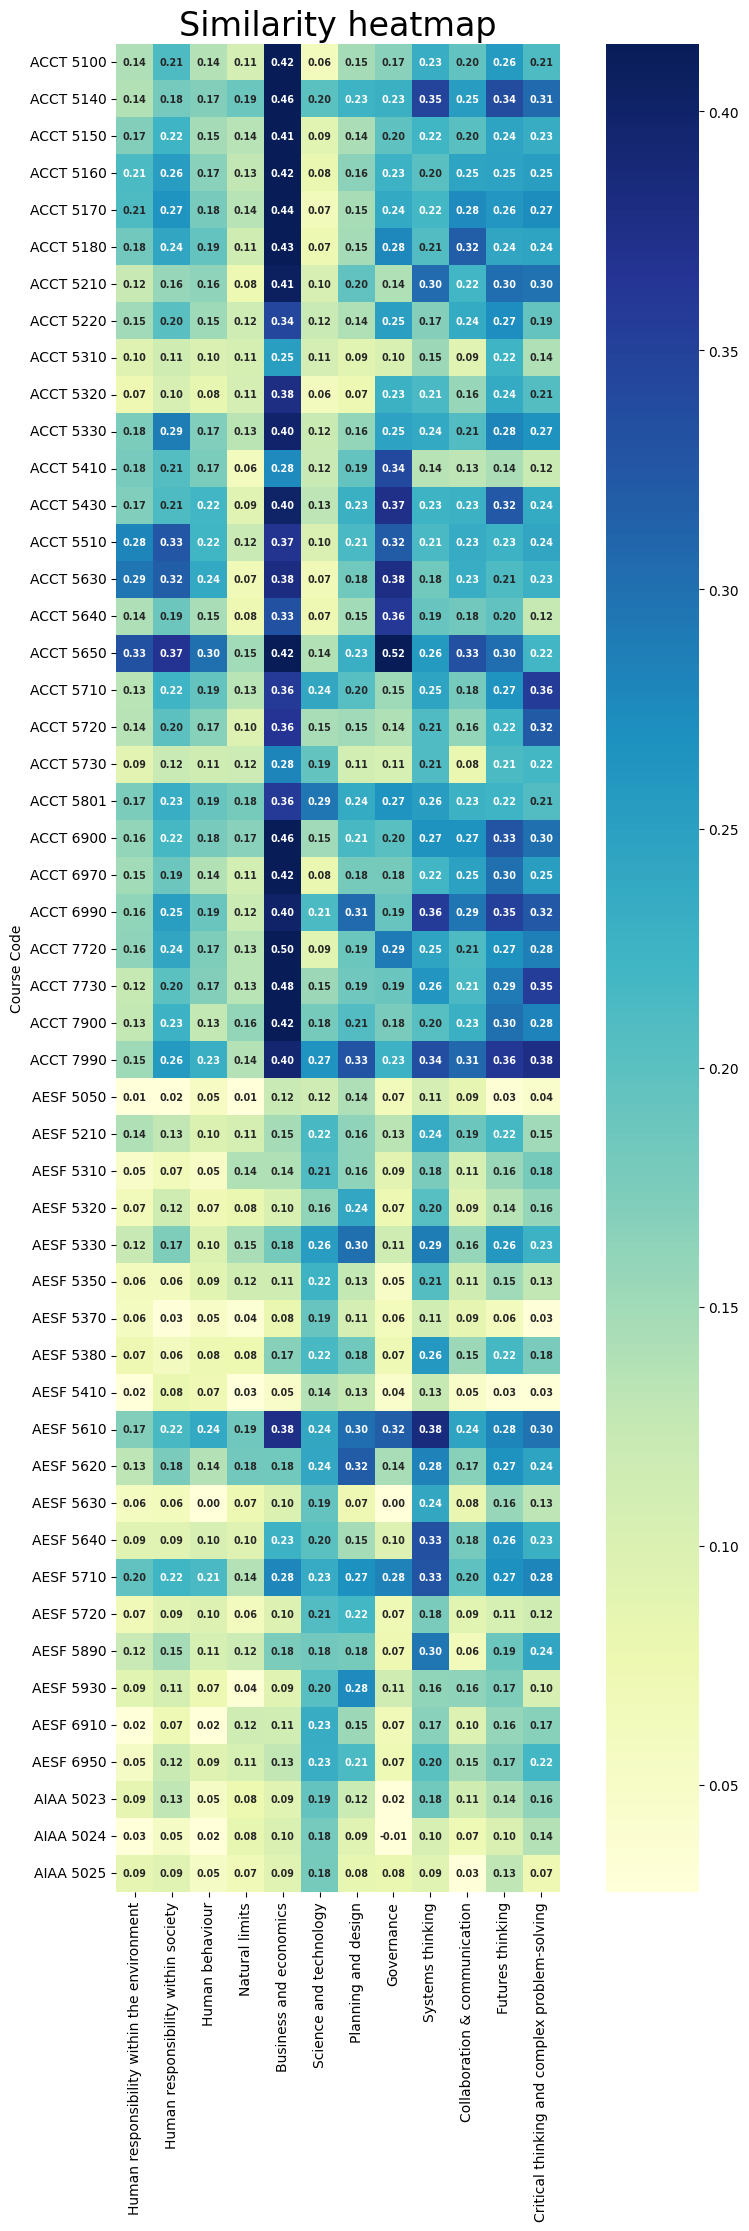

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

### Filter the matrix
# similarity_df = similarity_df[similarity_df > 0.4]

heatmap_df = similarity_df.head(50)

# Create the heatmap
plt.figure(figsize=(12, 24))
sns.heatmap (
  heatmap_df,
  square=True, 
  annot=True, 
  robust=True,
  fmt='.2f',
  annot_kws={'size': 'x-small', 'fontweight': 'bold'},
  # yticklabels = similarity_df.columns,
  # xticklabels = similarity_df.index,
  cmap="YlGnBu"
  )

plt.title('Similarity heatmap', fontdict={'fontsize': 24})
plt.show()

## 4. End